# Europe Clustering

The code of the DIANA algorithm is from Github and changed to fit this data. 

## Dataframe Gender

In [1]:
!pip install scikit-learn-extra

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn_extra.cluster import KMedoids
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score

In [3]:
df = pd.read_excel('./data/Gender_StatsEXCEL.xlsx',sheet_name='Data')

In [4]:
df = df.iloc[54000:,]
df.drop(columns=df.iloc[:,3:54].columns.tolist(), inplace=True)
df.rename({'Indicator Name':'Indicator'},inplace=True,axis=1)
df.rename({'Country Name':'Country'},inplace=True,axis=1)
df = df.loc[df.Indicator.str.contains('1=yes; 0=no')]
df = df.assign(Mean_GV=df.mean(axis=1, numeric_only=True))
df.drop(columns=df.iloc[:,3:16].columns.tolist(), inplace=True)
del df['Country Code']
df = pd.pivot(df, index=['Country'], columns = 'Indicator',values = 'Mean_GV')

In [5]:
importances = np.array([0.01831044, 0.03237455, 0.0031967 , 0.012108  , 0.01552896,
       0.00758614, 0.00181886, 0.0546642 , 0.01587967, 0.01247531,
       0.02007783, 0.0364012 , 0.03424009, 0.03465867, 0.02593966,
       0.01570586, 0.05781482, 0.01149065, 0.00752398, 0.05290953,
       0.07132007, 0.01305223, 0.03959353, 0.04099451, 0.02862905,
       0.00649011, 0.00942123, 0.00436768, 0.03333931, 0.02942839,
       0.02490152, 0.02989014, 0.0245622 , 0.05561928, 0.11768564])

In [6]:
df.iloc[:,] *= importances
df = df.assign(Gender_Var=df.sum(axis=1, numeric_only=True))
df.dropna(axis=0, inplace = True)
df.drop(columns=df.iloc[:,0:35].columns.tolist(), inplace=True)

## Dataframe Gini

In [7]:
df1 = pd.read_excel('./data/Gender_StatsEXCEL.xlsx',sheet_name='Data')

In [8]:
df1 = df1.iloc[54000:,]
df1.drop(columns=df1.iloc[:,3:54].columns.tolist(), inplace=True)
df1.rename({'Indicator Name':'Indicator'},inplace=True,axis=1)
df1.rename({'Country Name':'Country'},inplace=True,axis=1)
df1 = df1.loc[df1.Indicator.str.contains('Gini index')]
df1 = df1.assign(Gini_Var=df1.mean(axis=1, numeric_only=True))
df1.drop(columns=df1.iloc[:,1:16].columns.tolist(), inplace=True)
df1.dropna(axis=0, inplace = True)

## Dataframe Growth

In [9]:
df2 = pd.read_excel('./data/Gender_StatsEXCEL.xlsx',sheet_name='Data')

In [10]:
df2 = df2.iloc[54000:,]
df2.drop(columns=df2.iloc[:,3:54].columns.tolist(), inplace=True)
df2.rename({'Indicator Name':'Indicator'},inplace=True,axis=1)
df2.rename({'Country Name':'Country'},inplace=True,axis=1)
df2 = df2.loc[df2.Indicator.str.contains('GDP growth')]
df2 = df2.assign(Growth_Var=df2.mean(axis=1, numeric_only=True))
df2.drop(columns=df2.iloc[:,1:16].columns.tolist(), inplace=True)
df2.dropna(axis=0, inplace = True)

## Dataframe continents

In [11]:
df_Continent = pd.read_excel('./data/Gender_StatsEXCEL.xlsx',sheet_name='Country')

In [12]:
print(df_Continent['Region'].unique())

['Latin America & Caribbean' nan 'South Asia' 'Sub-Saharan Africa'
 'Europe & Central Asia' 'Middle East & North Africa'
 'East Asia & Pacific' 'North America']


In [13]:
df_Continent['Region'].value_counts()

Europe & Central Asia         58
Sub-Saharan Africa            48
Latin America & Caribbean     42
East Asia & Pacific           37
Middle East & North Africa    21
South Asia                     8
North America                  3
Name: Region, dtype: int64

In [14]:
df_Continent = df_Continent[['Table Name', 'Region']]
df_Continent.rename({'Table Name':'Country'},inplace=True,axis=1)
df_Continent.dropna(axis=0, inplace = True)

## Dataframe Gender-Growth

In [16]:
df_Gender_Growth = df.merge(df2,how='inner',left_on='Country', right_on='Country')
df_Gender_Growth = df_Gender_Growth.merge(df_Continent, how='inner',left_on='Country', right_on='Country')
df_Gender_Growth.head()

,Country,Gender_Var,Growth_Var,Region
0,Afghanistan,0.187844,2.019799,South Asia
1,Albania,0.750623,2.576940,Europe & Central Asia
2,Algeria,0.470927,2.108333,Middle East & North Africa
3,Angola,0.559647,1.527807,Sub-Saharan Africa
4,Antigua and Barbuda,0.473140,0.504912,Latin America & Caribbean


## Dataframe Gini-Growth

In [17]:
df_Gini_Growth = df1.merge(df2,how='inner',left_on='Country', right_on='Country')
df_Gini_Growth = df_Gini_Growth.merge(df_Continent, how='inner',left_on='Country', right_on='Country')
df_Gini_Growth.head()

,Country,Gini_Var,Growth_Var,Region
0,Albania,32.014286,2.576940,Europe & Central Asia
1,Algeria,27.600000,2.108333,Middle East & North Africa
2,Angola,51.300000,1.527807,Sub-Saharan Africa
3,Argentina,41.960000,1.191811,Latin America & Caribbean
4,Armenia,30.827273,3.600000,Europe & Central Asia


## Filter on Europe and Central Asia

In [18]:
df_Gender_Growth_EU_CA = df_Gender_Growth.loc[df_Gender_Growth['Region'] == 'Europe & Central Asia']
df_Gini_Growth_EU_CA = df_Gini_Growth.loc[df_Gini_Growth['Region'] == 'Europe & Central Asia']

In [26]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']))

## Gender-Growth Variable

### K-means clustering

In [59]:
df_Gender_Growth_EU_CA_K = df_Gender_Growth_EU_CA[['Gender_Var', 'Growth_Var']]

In [60]:
sse_ = []
for k in range(2,10):
    kmeans = KMeans(n_clusters = k, random_state = 42).fit(df_Gender_Growth_EU_CA_K)
    sse_.append([k, silhouette_score(df_Gender_Growth_EU_CA_K, kmeans.labels_)])
sse_

[[2, 0.5963165723955167],
 [3, 0.5890753238132805],
 [4, 0.6265300884859509],
 [5, 0.5671017201044156],
 [6, 0.5903558485859558],
 [7, 0.5687086002044124],
 [8, 0.5452780756108417],
 [9, 0.5254056174247367]]

In [61]:
DB_ = []
for k in range(2,10):
    kmeans = KMeans(n_clusters = k, random_state = 42).fit(df_Gender_Growth_EU_CA_K)
    DB_.append([k, davies_bouldin_score(df_Gender_Growth_EU_CA_K, kmeans.labels_)])
DB_

[[2, 0.6117447794561972],
 [3, 0.5834564134916063],
 [4, 0.4609120096261584],
 [5, 0.44387650835070314],
 [6, 0.4046996711979001],
 [7, 0.43417031194557165],
 [8, 0.44305111629063754],
 [9, 0.413387550977876]]

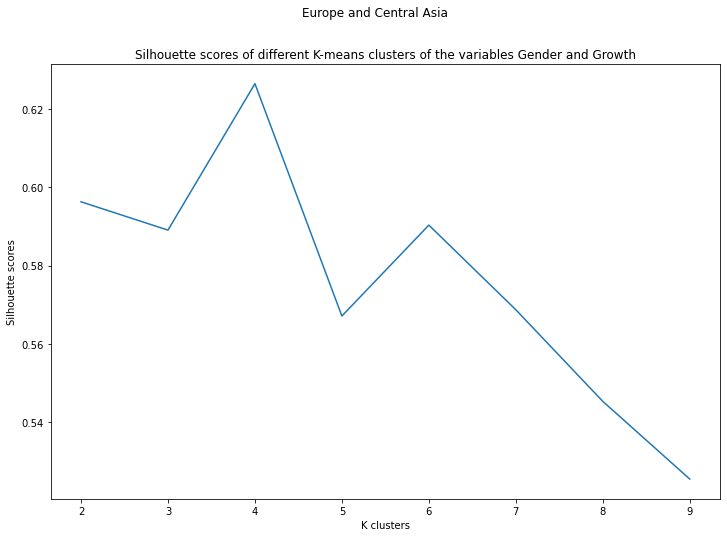

In [62]:
fig = plt.figure(figsize = (12,8))
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1])
plt.title("Silhouette scores of different K-means clusters of the variables Gender and Growth")
plt.ylabel("Silhouette scores")
plt.xlabel("K clusters")
plt.suptitle("Europe and Central Asia")
plt.show()

In [63]:
model_clus1 = KMeans(n_clusters = 4, random_state = 42)
model_clus1.fit(df_Gender_Growth_EU_CA_K)
data1 = df_Gender_Growth_EU_CA_K
data1.index = pd.RangeIndex(len(data1.index))
df_Gender_Growth_EU_CA_K = pd.concat([data1, pd.Series(model_clus1.labels_)], axis = 1)
df_Gender_Growth_EU_CA_K.columns = ['Gender_Var', 'Growth_Var', 'ClusterID_K']
df_Gender_Growth_EU_CA_K['ClusterID_K'].value_counts()

0    30
3     9
2     6
1     3
Name: ClusterID_K, dtype: int64

In [64]:
 df_Gender_Growth_EU_CA = pd.merge(df_Gender_Growth_EU_CA,  df_Gender_Growth_EU_CA_K, how = 'inner', left_on=['Gender_Var', 'Growth_Var'], right_on=['Gender_Var', 'Growth_Var'])

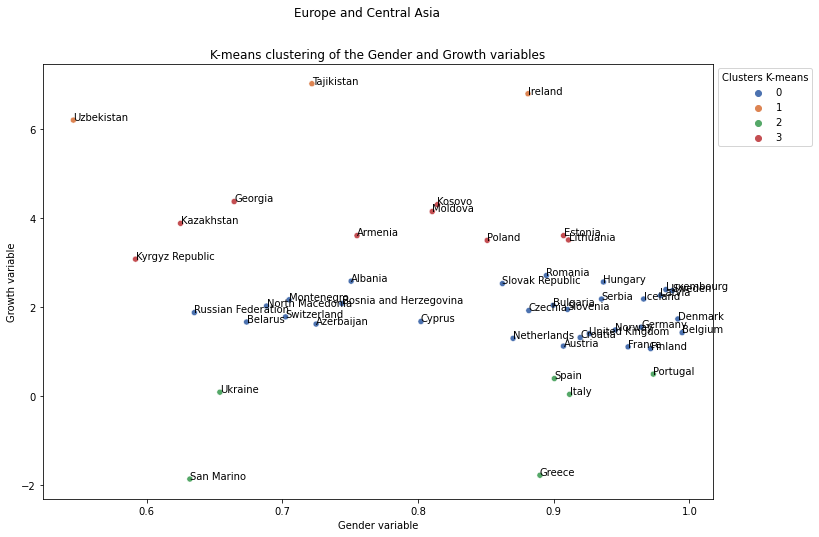

In [65]:
fig = plt.figure(figsize = (12,8))
sns.scatterplot(x='Gender_Var', y = 'Growth_Var', hue = 'ClusterID_K', legend = 'full', palette="deep", data = df_Gender_Growth_EU_CA)
plt.title('K-means clustering of the Gender and Growth variables')
plt.suptitle("Europe and Central Asia")
plt.ylabel("Growth variable")
plt.xlabel("Gender variable")
label_point(df_Gender_Growth_EU_CA.Gender_Var, df_Gender_Growth_EU_CA.Growth_Var, df_Gender_Growth_EU_CA.Country, plt.gca()) 
plt.legend(title='Clusters K-means', loc='center left', bbox_to_anchor = (1,0.9))
plt.show()

In [66]:
Cluster_Gender = pd.DataFrame(df_Gender_Growth_EU_CA.groupby(['ClusterID_K']).Gender_Var.mean())
Cluster_Growth = pd.DataFrame(df_Gender_Growth_EU_CA.groupby(['ClusterID_K']).Growth_Var.mean())
dt_EU_CA_knn_Gender_Growth = pd.concat([Cluster_Gender, Cluster_Growth], axis = 1)
dt_EU_CA_knn_Gender_Growth

,Gender_Var,Growth_Var
ClusterID_K,,
0,0.870142,1.864275
1,0.716206,6.662249
2,0.826805,-0.440269
3,0.769955,3.771214


### K-medoids clustering

In [67]:
df_Gender_Growth_EU_CA_KM = df_Gender_Growth_EU_CA[['Gender_Var', 'Growth_Var']]

In [68]:
sse_ = []
for k in range(2,10):
    kmedoids = KMedoids(n_clusters = k, method = 'pam', random_state = 42).fit(df_Gender_Growth_EU_CA_KM)
    sse_.append([k, silhouette_score(df_Gender_Growth_EU_CA_KM, kmedoids.labels_)])
sse_

[[2, 0.5963165723955167],
 [3, 0.5858747077036434],
 [4, 0.6265300884859509],
 [5, 0.5316725919187056],
 [6, 0.5903558485859558],
 [7, 0.5687086002044124],
 [8, 0.5476804461269416],
 [9, 0.5181919030398194]]

In [69]:
DB_ = []
for k in range(2,10):
    kmedoids = KMedoids(n_clusters = k, random_state = 42).fit(df_Gender_Growth_EU_CA_KM)
    DB_.append([k, davies_bouldin_score(df_Gender_Growth_EU_CA_KM, kmedoids.labels_)])
DB_

[[2, 0.7862261010052981],
 [3, 0.7079505899231671],
 [4, 0.7356739510720238],
 [5, 0.6481110664184604],
 [6, 0.654624254152648],
 [7, 0.6995701275018806],
 [8, 0.5897405756770431],
 [9, 0.6431770342185661]]

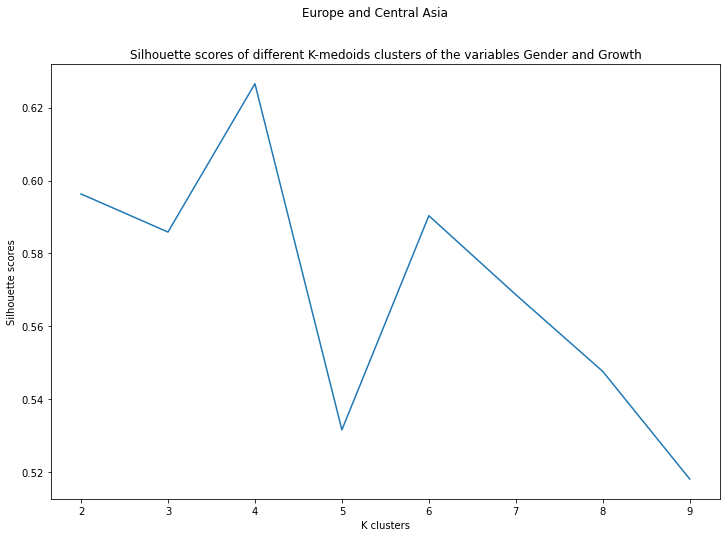

In [70]:
fig = plt.figure(figsize = (12,8))
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1])
plt.title("Silhouette scores of different K-medoids clusters of the variables Gender and Growth")
plt.ylabel("Silhouette scores")
plt.xlabel("K clusters")
plt.suptitle("Europe and Central Asia")
plt.show()

In [71]:
model_clus2 = KMedoids(n_clusters = 4, random_state = 42, method = 'pam')
model_clus2.fit(df_Gender_Growth_EU_CA_KM)
data2 = df_Gender_Growth_EU_CA_KM
data2.index = pd.RangeIndex(len(data2.index))
df_Gender_Growth_EU_CA_KM = pd.concat([data2, pd.Series(model_clus2.labels_)], axis = 1)
df_Gender_Growth_EU_CA_KM.columns = ['Gender_Var', 'Growth_Var', 'ClusterID_KM']
df_Gender_Growth_EU_CA_KM['ClusterID_KM'].value_counts()

2    30
1     9
0     6
3     3
Name: ClusterID_KM, dtype: int64

In [72]:
df_Gender_Growth_EU_CA = pd.merge(df_Gender_Growth_EU_CA, df_Gender_Growth_EU_CA_KM, how = 'inner', left_on=['Gender_Var', 'Growth_Var'], right_on=['Gender_Var', 'Growth_Var'])

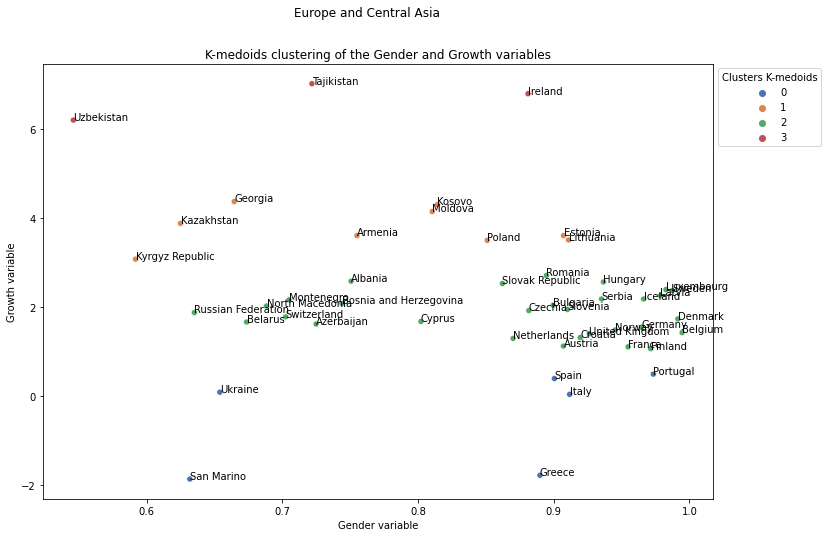

In [73]:
fig = plt.figure(figsize = (12,8))
sns.scatterplot(x='Gender_Var', y = 'Growth_Var', hue = 'ClusterID_KM', legend = 'full', palette="deep", data = df_Gender_Growth_EU_CA)
plt.title('K-medoids clustering of the Gender and Growth variables')
plt.suptitle("Europe and Central Asia")
plt.ylabel("Growth variable")
plt.xlabel("Gender variable")
label_point(df_Gender_Growth_EU_CA.Gender_Var, df_Gender_Growth_EU_CA.Growth_Var, df_Gender_Growth_EU_CA.Country, plt.gca()) 
plt.legend(title='Clusters K-medoids', loc='center left', bbox_to_anchor = (1,0.9))
plt.show()

In [74]:
Cluster_Gender = pd.DataFrame(df_Gender_Growth_EU_CA_KM.groupby(['ClusterID_KM']).Gender_Var.mean())
Cluster_Growth = pd.DataFrame(df_Gender_Growth_EU_CA_KM.groupby(['ClusterID_KM']).Growth_Var.mean())
dt_EU_CA_km_Gender_Growth = pd.concat([Cluster_Gender, Cluster_Growth], axis = 1)
dt_EU_CA_km_Gender_Growth

,Gender_Var,Growth_Var
ClusterID_KM,,
0,0.826805,-0.440269
1,0.769955,3.771214
2,0.870142,1.864275
3,0.716206,6.662249


### AGNES clustering

In [75]:
df_Gender_Growth_EU_CA_A = df_Gender_Growth_EU_CA[['Gender_Var', 'Growth_Var']]

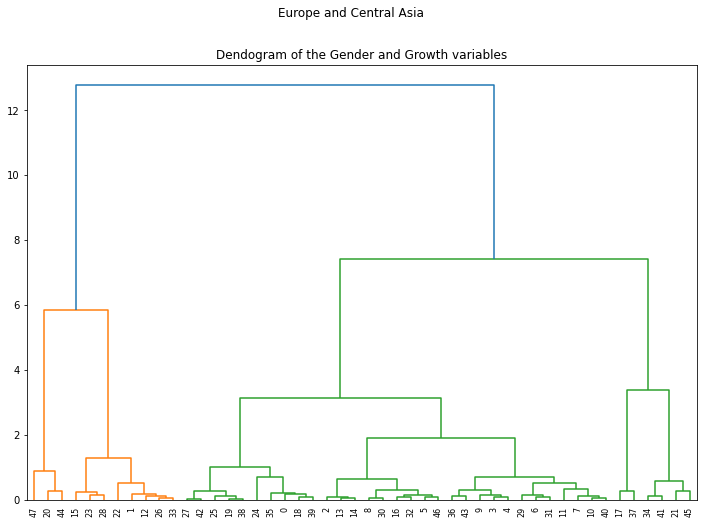

In [76]:
fig = plt.figure(figsize = (12,8))
plt.title('Dendogram of the Gender and Growth variables')
plt.suptitle("Europe and Central Asia")
dend = shc.dendrogram(shc.linkage(df_Gender_Growth_EU_CA_A, method = 'ward'))

In [77]:
sse_ = []
for k in range (2,10):
    clustering = AgglomerativeClustering(n_clusters = k, affinity = 'euclidean' ,linkage = 'ward')
    cluster_labels = clustering.fit_predict(df_Gender_Growth_EU_CA_A)
    silhouette_average = silhouette_score(df_Gender_Growth_EU_CA_A, cluster_labels)
    sse_.append([k, silhouette_average])
sse_

[[2, 0.601580148755977],
 [3, 0.5890753238132805],
 [4, 0.6167039081583385],
 [5, 0.5988130719397577],
 [6, 0.5387159723706904],
 [7, 0.5492586183148128],
 [8, 0.5369529567308284],
 [9, 0.5117685660885437]]

In [78]:
DB_ = []
for k in range (2,10):
    clustering = AgglomerativeClustering(n_clusters = k, affinity = 'euclidean' ,linkage = 'ward')
    cluster_labels = clustering.fit_predict(df_Gender_Growth_EU_CA_A)
    davies_bouldin = davies_bouldin_score(df_Gender_Growth_EU_CA_A, cluster_labels)
    DB_.append([k, davies_bouldin])
DB_

[[2, 0.6076896984425708],
 [3, 0.5834564134916062],
 [4, 0.455228812050765],
 [5, 0.32577380994858013],
 [6, 0.4192803371295129],
 [7, 0.45432365525264],
 [8, 0.4391460716036041],
 [9, 0.4491240388684685]]

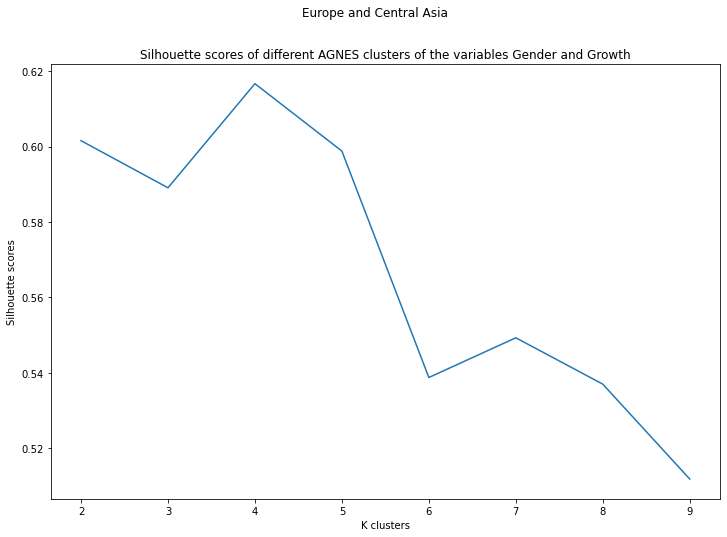

In [79]:
fig = plt.figure(figsize = (12,8))
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1])
plt.title("Silhouette scores of different AGNES clusters of the variables Gender and Growth")
plt.ylabel("Silhouette scores")
plt.xlabel("K clusters")
plt.suptitle("Europe and Central Asia")
plt.show()

In [80]:
cluster = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean' ,linkage = 'ward')
ClusterID_A = cluster.fit_predict(df_Gender_Growth_EU_CA_A)
ClusterID_A

array([2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 0, 2, 2, 3, 0,
       1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2,
       3, 0, 2, 3])

In [81]:
df_Gender_Growth_EU_CA['ClusterID_A'] = [2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 0, 2, 2, 3, 0,
       1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2,
       3, 0, 2, 3]

In [82]:
df_Gender_Growth_EU_CA['ClusterID_A'].value_counts()

2    31
1     8
0     6
3     3
Name: ClusterID_A, dtype: int64

In [83]:
df_Gender_Growth_EU_CA.head()

,Country,Gender_Var,Growth_Var,Region,ClusterID_K,ClusterID_KM,ClusterID_A
0,Albania,0.750623,2.576940,Europe & Central Asia,0,2,2
1,Armenia,0.754951,3.600000,Europe & Central Asia,3,1,1
2,Austria,0.907093,1.119607,Europe & Central Asia,0,2,2
3,Azerbaijan,0.724794,1.614042,Europe & Central Asia,0,2,2
4,Belarus,0.673581,1.659967,Europe & Central Asia,0,2,2


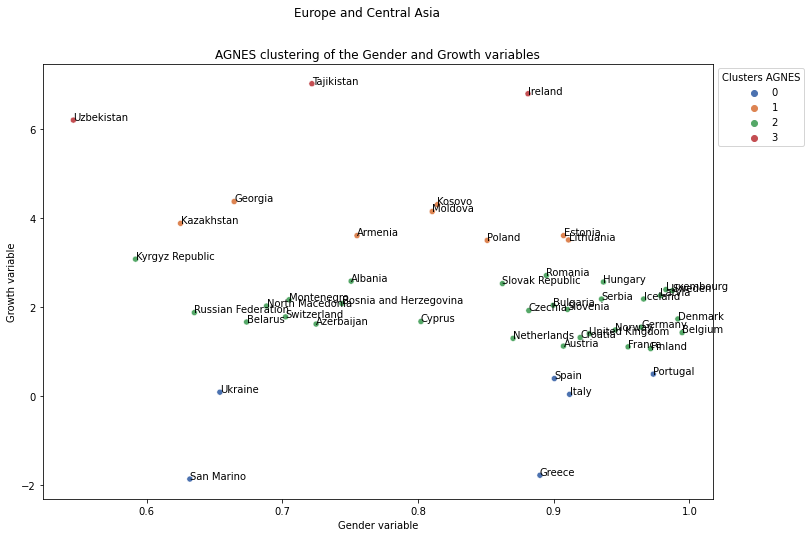

In [84]:
fig = plt.figure(figsize = (12,8))
sns.scatterplot(x='Gender_Var', y = 'Growth_Var', hue = 'ClusterID_A', legend = 'full', palette="deep", data = df_Gender_Growth_EU_CA)
plt.title('AGNES clustering of the Gender and Growth variables')
plt.suptitle("Europe and Central Asia")
plt.ylabel("Growth variable")
plt.xlabel("Gender variable")
label_point(df_Gender_Growth_EU_CA.Gender_Var, df_Gender_Growth_EU_CA.Growth_Var, df_Gender_Growth_EU_CA.Country, plt.gca()) 
plt.legend(title='Clusters AGNES', loc='center left', bbox_to_anchor = (1,0.9))
plt.show()

### DIANA clustering

In [85]:
df_Gender_Growth_EU_CA_D = df_Gender_Growth_EU_CA[['Gender_Var', 'Growth_Var']]

In [86]:
from scipy.spatial import distance_matrix

def DIANA(data, n_clusters):
    n_samples = len(data)
    n_features = 2
    similarity_matrix = distance_matrix(data.values, data.values) # similarity matrix of the data
    clusters = [list(range(n_samples))]      # list of clusters, initially the whole dataset is a single cluster
    while True:
        c_diameters = [np.max(similarity_matrix[cluster][:, cluster]) for cluster in clusters]  #cluster diameters
        max_cluster_dia = np.argmax(c_diameters)  #maximum cluster diameter
        max_difference_index = np.argmax(np.mean(similarity_matrix[clusters[max_cluster_dia]][:, clusters[max_cluster_dia]], axis=1))
        splinters = [clusters[max_cluster_dia][max_difference_index]] #spinter group
        last_clusters = clusters[max_cluster_dia]
        del last_clusters[max_difference_index]
        while True:
            split = False
            for j in range(len(last_clusters))[::-1]:
                splinter_distances = similarity_matrix[last_clusters[j], splinters]
                last_distances = similarity_matrix[last_clusters[j], np.delete(last_clusters, j, axis=0)]
                if np.mean(splinter_distances) <= np.mean(last_distances):
                    splinters.append(last_clusters[j])
                    del last_clusters[j]
                    split = True
                    break
            if split == False:
                break
        del clusters[max_cluster_dia]
        clusters.append(splinters)
        clusters.append(last_clusters)
        if len(clusters) == n_clusters:
            break

    cluster_labels = np.zeros(n_samples)
    for i in range(len(clusters)):
        cluster_labels[clusters[i]] = i

    return cluster_labels

In [87]:
sse_ = []
for k in range (2,10):
    clustering = DIANA(df_Gender_Growth_EU_CA_D, k)
    silhouette_average = silhouette_score(df_Gender_Growth_EU_CA_D, clustering)
    sse_.append([k, silhouette_average])
sse_

[[2, 0.5963165723955167],
 [3, 0.6129400716064047],
 [4, 0.6156669385328885],
 [5, 0.5668810396999742],
 [6, 0.5491419268682768],
 [7, 0.4372849860972501],
 [8, 0.4782359802559128],
 [9, 0.5147743470635731]]

In [88]:
DB_ = []
for k in range (2,10):
    clustering = DIANA(df_Gender_Growth_EU_CA_D, k)
    davies_bouldin = davies_bouldin_score(df_Gender_Growth_EU_CA_D, clustering)
    DB_.append([k, davies_bouldin])
DB_

[[2, 0.6117447794561972],
 [3, 0.45757591921029467],
 [4, 0.33617802789797113],
 [5, 0.4457767762100402],
 [6, 0.38741130656585393],
 [7, 0.3915847990482959],
 [8, 0.44853703033893544],
 [9, 0.42577807724252636]]

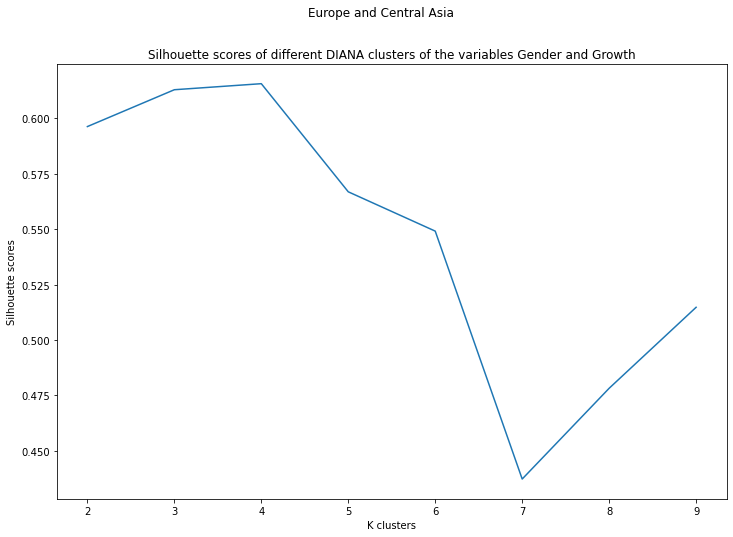

In [89]:
fig = plt.figure(figsize = (12,8))
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1])
plt.title("Silhouette scores of different DIANA clusters of the variables Gender and Growth")
plt.ylabel("Silhouette scores")
plt.xlabel("K clusters")
plt.suptitle("Europe and Central Asia")
plt.show()

In [90]:
DIANA(df_Gender_Growth_EU_CA_D, 4)

array([1., 3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 3., 1., 1., 3., 1.,
       0., 1., 1., 2., 1., 3., 3., 3., 1., 3., 1., 3., 1., 1., 1., 1., 3.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 2., 1., 1., 2.])

In [91]:
df_Gender_Growth_EU_CA['ClusterID_D'] = [round(float(i)) for i in [1., 3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 3., 1., 1., 3., 1.,
       0., 1., 1., 2., 1., 3., 3., 3., 1., 3., 1., 3., 1., 1., 1., 1., 3.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 2., 1., 1., 2.]]

In [92]:
df_Gender_Growth_EU_CA['ClusterID_D'].value_counts()

1    34
3     9
2     3
0     2
Name: ClusterID_D, dtype: int64

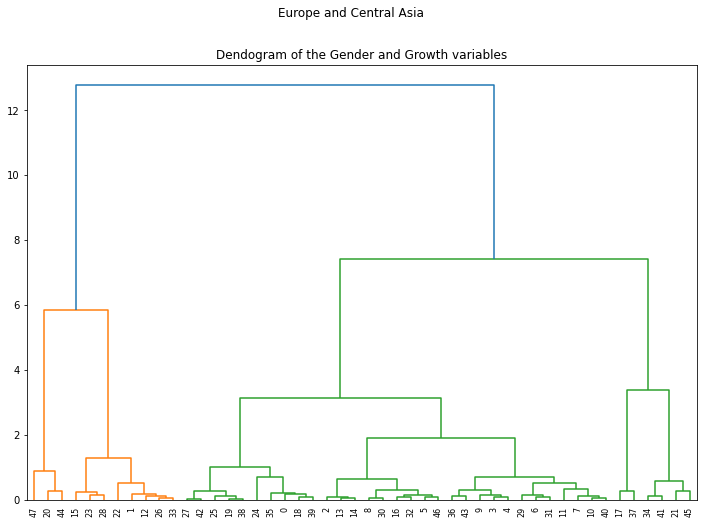

In [93]:
fig = plt.figure(figsize = (12,8))
plt.title('Dendogram of the Gender and Growth variables')
plt.suptitle("Europe and Central Asia")
dend = shc.dendrogram(shc.linkage(df_Gender_Growth_EU_CA_D, method = 'ward'))

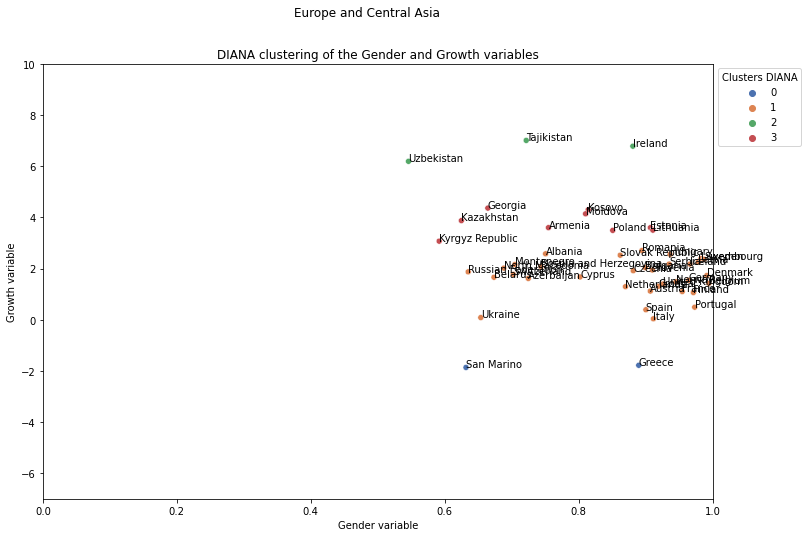

In [94]:
fig = plt.figure(figsize = (12,8))
sns.scatterplot(x='Gender_Var', y = 'Growth_Var', hue = 'ClusterID_D', legend = 'full', palette="deep", data = df_Gender_Growth_EU_CA)
plt.title('DIANA clustering of the Gender and Growth variables')
plt.suptitle("Europe and Central Asia")
plt.ylabel("Growth variable")
plt.xlabel("Gender variable")
label_point(df_Gender_Growth_EU_CA.Gender_Var, df_Gender_Growth_EU_CA.Growth_Var, df_Gender_Growth_EU_CA.Country, plt.gca()) 
plt.xlim([0,1])
plt.ylim([-7,10])
plt.legend(title='Clusters DIANA', loc='center left', bbox_to_anchor = (1,0.9))
plt.show()

In [95]:
Cluster_Gender = pd.DataFrame(df_Gender_Growth_EU_CA.groupby(['ClusterID_D']).Gender_Var.mean())
Cluster_Growth = pd.DataFrame(df_Gender_Growth_EU_CA.groupby(['ClusterID_D']).Growth_Var.mean())
dt_EU_CA_D_Gender_Growth = pd.concat([Cluster_Gender, Cluster_Growth], axis = 1)
dt_EU_CA_D_Gender_Growth

,Gender_Var,Growth_Var
ClusterID_D,,
0,0.760769,-1.822535
1,0.868928,1.674462
2,0.716206,6.662249
3,0.769955,3.771214


## Growth-Gini Variable

### K-means clustering

In [97]:
df_Gini_Growth_EU_CA_K = df_Gini_Growth_EU_CA[['Growth_Var', 'Gini_Var']]

In [98]:
sse_ = []
for k in range(2,10):
    kmeans = KMeans(n_clusters = k, random_state = 42).fit(df_Gini_Growth_EU_CA_K)
    sse_.append([k, silhouette_score(df_Gini_Growth_EU_CA_K, kmeans.labels_)])
sse_

[[2, 0.5095715896452886],
 [3, 0.49113195005719634],
 [4, 0.4400775129206814],
 [5, 0.49431712056588556],
 [6, 0.43849351525336455],
 [7, 0.46755281213424943],
 [8, 0.4566008180789444],
 [9, 0.4746301105904654]]

In [99]:
DB_ = []
for k in range(2,10):
    kmeans = KMeans(n_clusters = k, random_state = 42).fit(df_Gini_Growth_EU_CA_K)
    DB_.append([k, davies_bouldin_score(df_Gini_Growth_EU_CA_K, kmeans.labels_)])
DB_

[[2, 0.668987369680174],
 [3, 0.7604661609869484],
 [4, 0.7895344750461343],
 [5, 0.6410975131266198],
 [6, 0.6936424040028929],
 [7, 0.6286220090530704],
 [8, 0.6824095171583722],
 [9, 0.654408201619498]]

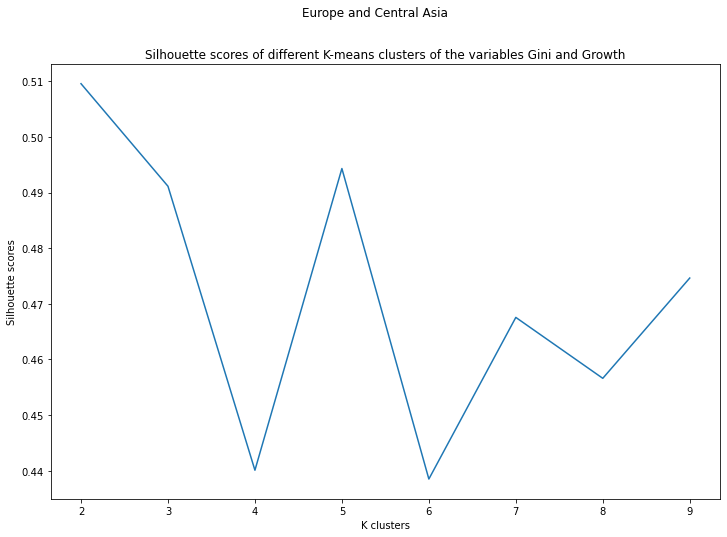

In [100]:
fig = plt.figure(figsize = (12,8))
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1])
plt.title("Silhouette scores of different K-means clusters of the variables Gini and Growth")
plt.ylabel("Silhouette scores")
plt.xlabel("K clusters")
plt.suptitle("Europe and Central Asia")
plt.show()

In [101]:
model_clus1 = KMeans(n_clusters = 5, random_state = 42)
model_clus1.fit(df_Gini_Growth_EU_CA_K)
data1 = df_Gini_Growth_EU_CA_K
data1.index = pd.RangeIndex(len(data1.index))
df_Gini_Growth_EU_CA_K = pd.concat([data1, pd.Series(model_clus1.labels_)], axis = 1)
df_Gini_Growth_EU_CA_K.columns = ['Growth_Var', 'Gini_Var', 'ClusterID_K']
df_Gini_Growth_EU_CA_K['ClusterID_K'].value_counts()

2    16
1    13
0     8
4     6
3     2
Name: ClusterID_K, dtype: int64

In [102]:
df_Gini_Growth_EU_CA = pd.merge(df_Gini_Growth_EU_CA,  df_Gini_Growth_EU_CA_K, how = 'inner', left_on=['Growth_Var', 'Gini_Var'], right_on=['Growth_Var', 'Gini_Var'])

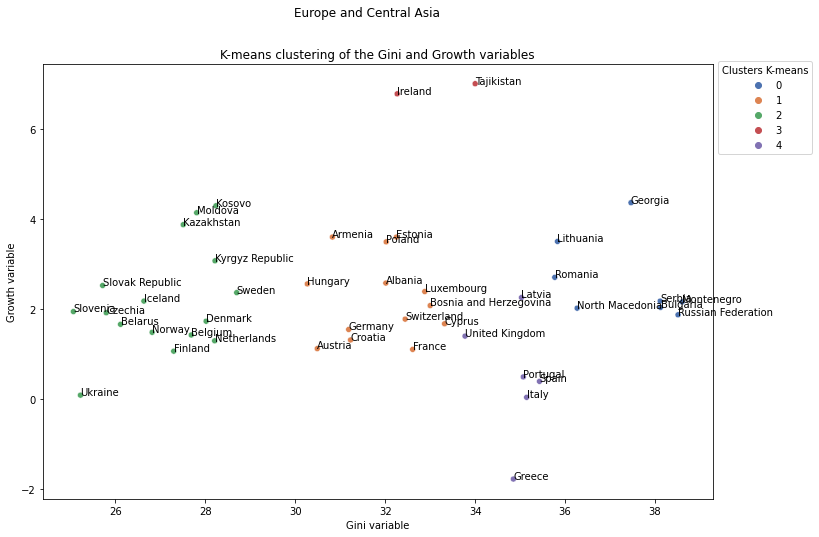

In [103]:
fig = plt.figure(figsize = (12,8))
sns.scatterplot(x='Gini_Var', y = 'Growth_Var', hue = 'ClusterID_K', legend = 'full', palette="deep", data = df_Gini_Growth_EU_CA_K)
plt.title('K-means clustering of the Gini and Growth variables')
plt.suptitle("Europe and Central Asia")
plt.ylabel("Growth variable")
plt.xlabel("Gini variable")
label_point(df_Gini_Growth_EU_CA_K.Gini_Var, df_Gini_Growth_EU_CA_K.Growth_Var, df_Gini_Growth_EU_CA.Country, plt.gca()) 
plt.legend(title='Clusters K-means', loc='center left', bbox_to_anchor = (1,0.9))
plt.show()

In [104]:
Cluster_Growth = pd.DataFrame(df_Gini_Growth_EU_CA.groupby(['ClusterID_K']).Growth_Var.mean())
Cluster_Gini = pd.DataFrame(df_Gini_Growth_EU_CA.groupby(['ClusterID_K']).Gini_Var.mean())
dt_EU_CA_knn_Growth_Gini = pd.concat([Cluster_Growth, Cluster_Gini], axis = 1)
dt_EU_CA_knn_Growth_Gini

,Growth_Var,Gini_Var
ClusterID_K,,
0,2.603828,37.333987
1,2.216708,31.888325
2,2.189961,27.068109
3,6.897026,33.133333
4,0.465199,34.883241


### K-medoids clustering

In [105]:
df_Gini_Growth_EU_CA_KM = df_Gini_Growth_EU_CA[['Growth_Var', 'Gini_Var']]

In [106]:
sse_ = []
for k in range(2,10):
    kmedoids = KMedoids(n_clusters = k, method = 'pam', random_state = 42).fit(df_Gini_Growth_EU_CA_KM)
    sse_.append([k, silhouette_score(df_Gini_Growth_EU_CA_KM, kmedoids.labels_)])
sse_

[[2, 0.521004865460238],
 [3, 0.49113195005719634],
 [4, 0.44028794693836093],
 [5, 0.48180933274122234],
 [6, 0.43733752318160024],
 [7, 0.4352863554189797],
 [8, 0.4591954635055642],
 [9, 0.4856129804498555]]

In [107]:
DB_ = []
for k in range(2,10):
    kmedoids = KMedoids(n_clusters = k, random_state = 42).fit(df_Gini_Growth_EU_CA_KM)
    DB_.append([k, davies_bouldin_score(df_Gini_Growth_EU_CA_KM, kmedoids.labels_)])
DB_

[[2, 0.668987369680174],
 [3, 0.7604661609869484],
 [4, 0.8559674183200328],
 [5, 0.7856342700484626],
 [6, 0.8533313256562343],
 [7, 0.9977887100742971],
 [8, 0.9851212390509645],
 [9, 0.8017774828636683]]

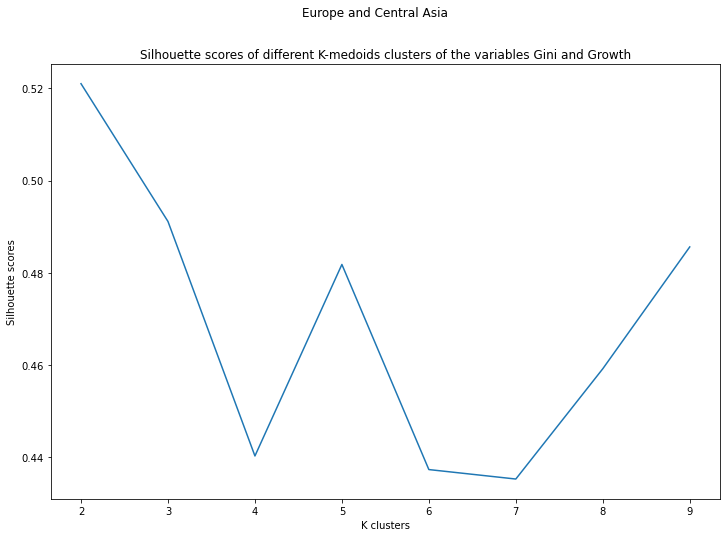

In [108]:
fig = plt.figure(figsize = (12,8))
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1])
plt.title("Silhouette scores of different K-medoids clusters of the variables Gini and Growth")
plt.ylabel("Silhouette scores")
plt.xlabel("K clusters")
plt.suptitle("Europe and Central Asia")
plt.show()

In [109]:
model_clus2 = KMedoids(n_clusters = 3, random_state = 42, method = 'pam')
model_clus2.fit(df_Gini_Growth_EU_CA_KM)
data2 = df_Gini_Growth_EU_CA_KM
data2.index = pd.RangeIndex(len(data2.index))
df_Gini_Growth_EU_CA_KM = pd.concat([data2, pd.Series(model_clus2.labels_)], axis = 1)
df_Gini_Growth_EU_CA_KM.columns = ['Growth_Var', 'Gini_Var', 'ClusterID_KM']
df_Gini_Growth_EU_CA_KM['ClusterID_KM'].value_counts()

0    16
2    16
1    13
Name: ClusterID_KM, dtype: int64

In [110]:
df_Gini_Growth_EU_CA = pd.merge(df_Gini_Growth_EU_CA, df_Gini_Growth_EU_CA_KM, how = 'inner', left_on=['Growth_Var', 'Gini_Var'], right_on=['Growth_Var', 'Gini_Var'])

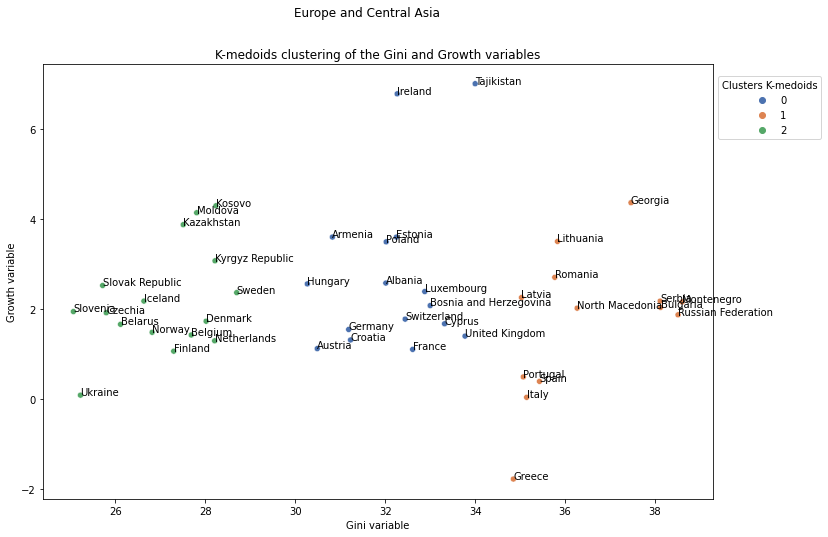

In [111]:
fig = plt.figure(figsize = (12,8))
sns.scatterplot(x='Gini_Var', y = 'Growth_Var', hue = 'ClusterID_KM', legend = 'full', palette="deep", data = df_Gini_Growth_EU_CA)
plt.title('K-medoids clustering of the Gini and Growth variables')
plt.suptitle("Europe and Central Asia")
plt.ylabel("Growth variable")
plt.xlabel("Gini variable")
label_point(df_Gini_Growth_EU_CA.Gini_Var, df_Gini_Growth_EU_CA.Growth_Var, df_Gini_Growth_EU_CA.Country, plt.gca()) 
plt.legend(title='Clusters K-medoids', loc='center left', bbox_to_anchor = (1,0.9))
plt.show()

In [112]:
Cluster_Growth = pd.DataFrame(df_Gini_Growth_EU_CA.groupby(['ClusterID_KM']).Growth_Var.mean())
Cluster_Gini = pd.DataFrame(df_Gini_Growth_EU_CA.groupby(['ClusterID_KM']).Gini_Var.mean())
dt_EU_CA_km_Growth_Gini = pd.concat([Cluster_Growth, Cluster_Gini], axis = 1)
dt_EU_CA_km_Growth_Gini

,Growth_Var,Gini_Var
ClusterID_KM,,
0,2.750552,32.161868
1,1.709557,36.476641
2,2.189961,27.068109


### AGNES algorithm

In [113]:
df_Gini_Growth_EU_CA_A = df_Gini_Growth_EU_CA[['Growth_Var', 'Gini_Var']]

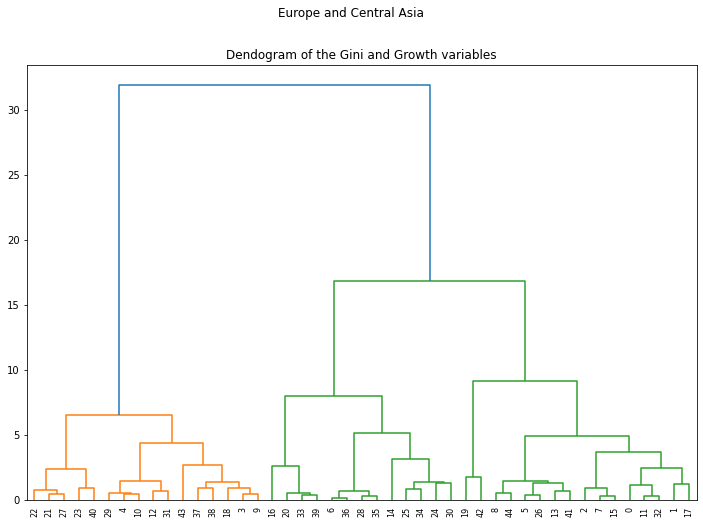

In [114]:
fig = plt.figure(figsize = (12,8))
plt.title('Dendogram of the Gini and Growth variables')
plt.suptitle("Europe and Central Asia")
dend = shc.dendrogram(shc.linkage(df_Gini_Growth_EU_CA_A, method = 'ward'))

In [115]:
sse_ = []
for k in range (2,10):
    clustering = AgglomerativeClustering(n_clusters = k, affinity = 'euclidean' ,linkage = 'ward')
    cluster_labels = clustering.fit_predict(df_Gini_Growth_EU_CA_A)
    silhouette_average = silhouette_score(df_Gini_Growth_EU_CA_A, cluster_labels)
    sse_.append([k, silhouette_average])
sse_

[[2, 0.521004865460238],
 [3, 0.49113195005719634],
 [4, 0.5146701882040289],
 [5, 0.5191374044611412],
 [6, 0.456658109918225],
 [7, 0.4808636811637867],
 [8, 0.4566008180789444],
 [9, 0.45369004937861435]]

In [116]:
DB_ = []
for k in range (2,10):
    clustering = AgglomerativeClustering(n_clusters = k, affinity = 'euclidean' ,linkage = 'ward')
    cluster_labels = clustering.fit_predict(df_Gini_Growth_EU_CA_A)
    davies_bouldin = davies_bouldin_score(df_Gini_Growth_EU_CA_A, cluster_labels)
    DB_.append([k, davies_bouldin])
DB_

[[2, 0.6050882357110938],
 [3, 0.7604661609869484],
 [4, 0.6099521037097804],
 [5, 0.578900840843354],
 [6, 0.6403007620562418],
 [7, 0.5953669645377578],
 [8, 0.6824095171583722],
 [9, 0.6557988135943034]]

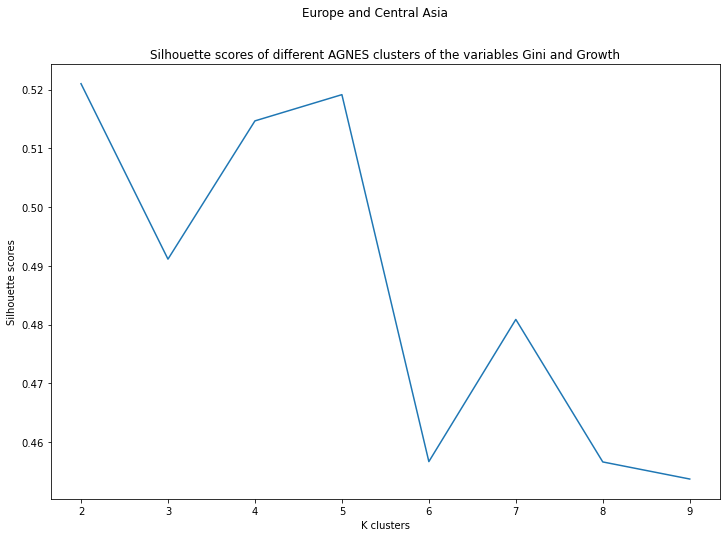

In [117]:
fig = plt.figure(figsize = (12,8))
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1])
plt.title("Silhouette scores of different AGNES clusters of the variables Gini and Growth")
plt.ylabel("Silhouette scores")
plt.xlabel("K clusters")
plt.suptitle("Europe and Central Asia")
plt.show()

In [118]:
cluster = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean' ,linkage = 'ward')
ClusterID_A = cluster.fit_predict(df_Gini_Growth_EU_CA_A)
ClusterID_A

array([2, 2, 2, 0, 0, 2, 1, 2, 2, 0, 0, 2, 0, 2, 1, 2, 4, 2, 0, 3, 4, 0,
       0, 0, 1, 1, 2, 0, 1, 0, 1, 0, 2, 4, 1, 1, 1, 0, 0, 4, 0, 2, 3, 0,
       2])

In [119]:
df_Gini_Growth_EU_CA['ClusterID_A'] = [2, 2, 2, 0, 0, 2, 1, 2, 2, 0, 0, 2, 0, 2, 1, 2, 4, 2, 0, 3, 4, 0,
       0, 0, 1, 1, 2, 0, 1, 0, 1, 0, 2, 4, 1, 1, 1, 0, 0, 4, 0, 2, 3, 0,
       2]

In [120]:
df_Gini_Growth_EU_CA['ClusterID_A'].value_counts()

0    16
2    14
1     9
4     4
3     2
Name: ClusterID_A, dtype: int64

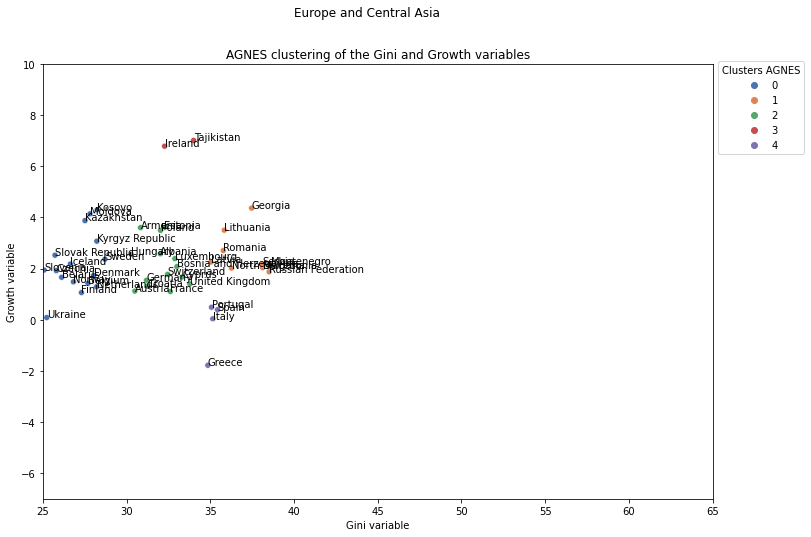

In [121]:
fig = plt.figure(figsize = (12,8))
sns.scatterplot(x='Gini_Var', y = 'Growth_Var', hue = 'ClusterID_A', legend = 'full', palette="deep", data = df_Gini_Growth_EU_CA)
plt.title('AGNES clustering of the Gini and Growth variables')
plt.suptitle("Europe and Central Asia")
plt.ylabel("Growth variable")
plt.xlabel("Gini variable")
label_point(df_Gini_Growth_EU_CA.Gini_Var, df_Gini_Growth_EU_CA.Growth_Var, df_Gini_Growth_EU_CA.Country, plt.gca()) 
plt.xlim([25,65])
plt.ylim([-7,10])
plt.legend(title='Clusters AGNES', loc='center left', bbox_to_anchor = (1,0.9))
plt.show()

In [122]:
Cluster_Growth = pd.DataFrame(df_Gini_Growth_EU_CA.groupby(['ClusterID_A']).Growth_Var.mean())
Cluster_Gini = pd.DataFrame(df_Gini_Growth_EU_CA.groupby(['ClusterID_A']).Gini_Var.mean())
dt_EU_CA_A_Growth_Gini = pd.concat([Cluster_Growth, Cluster_Gini], axis = 1)
dt_EU_CA_A_Growth_Gini

,Growth_Var,Gini_Var
ClusterID_A,,
0,2.189961,27.068109
1,2.565102,37.077988
2,2.158199,32.023088
3,6.897026,33.133333
4,-0.215420,35.123611


### DIANA clustering

In [123]:
df_Gini_Growth_EU_CA_D = df_Gini_Growth_EU_CA[['Growth_Var', 'Gini_Var']]

In [124]:
from scipy.spatial import distance_matrix

def DIANA(data, n_clusters):
    n_samples = len(data)
    n_features = 2
    similarity_matrix = distance_matrix(data.values, data.values) # similarity matrix of the data
    clusters = [list(range(n_samples))]      # list of clusters, initially the whole dataset is a single cluster
    while True:
        c_diameters = [np.max(similarity_matrix[cluster][:, cluster]) for cluster in clusters]  #cluster diameters
        max_cluster_dia = np.argmax(c_diameters)  #maximum cluster diameter
        max_difference_index = np.argmax(np.mean(similarity_matrix[clusters[max_cluster_dia]][:, clusters[max_cluster_dia]], axis=1))
        splinters = [clusters[max_cluster_dia][max_difference_index]] #spinter group
        last_clusters = clusters[max_cluster_dia]
        del last_clusters[max_difference_index]
        while True:
            split = False
            for j in range(len(last_clusters))[::-1]:
                splinter_distances = similarity_matrix[last_clusters[j], splinters]
                last_distances = similarity_matrix[last_clusters[j], np.delete(last_clusters, j, axis=0)]
                if np.mean(splinter_distances) <= np.mean(last_distances):
                    splinters.append(last_clusters[j])
                    del last_clusters[j]
                    split = True
                    break
            if split == False:
                break
        del clusters[max_cluster_dia]
        clusters.append(splinters)
        clusters.append(last_clusters)
        if len(clusters) == n_clusters:
            break

    cluster_labels = np.zeros(n_samples)
    for i in range(len(clusters)):
        cluster_labels[clusters[i]] = i

    return cluster_labels

In [125]:
sse_ = []
for k in range (2,10):
    clustering = DIANA(df_Gini_Growth_EU_CA_D, k)
    silhouette_average = silhouette_score(df_Gini_Growth_EU_CA_D, clustering)
    sse_.append([k, silhouette_average])
sse_

[[2, 0.5095715896452886],
 [3, 0.4092872423306773],
 [4, 0.39683803657913386],
 [5, 0.3541609481940033],
 [6, 0.3987517471353996],
 [7, 0.4274322235150184],
 [8, 0.3975421865526219],
 [9, 0.3889385895569638]]

In [126]:
DB_ = []
for k in range (2,10):
    clustering = DIANA(df_Gini_Growth_EU_CA_D, k)
    davies_bouldin = davies_bouldin_score(df_Gini_Growth_EU_CA_D, clustering)
    DB_.append([k, davies_bouldin])
DB_

[[2, 0.668987369680174],
 [3, 0.8657508286059111],
 [4, 0.7407781593018711],
 [5, 0.8874051391084778],
 [6, 0.7570558883861875],
 [7, 0.753563603038543],
 [8, 0.7022886692409688],
 [9, 0.7008940652511045]]

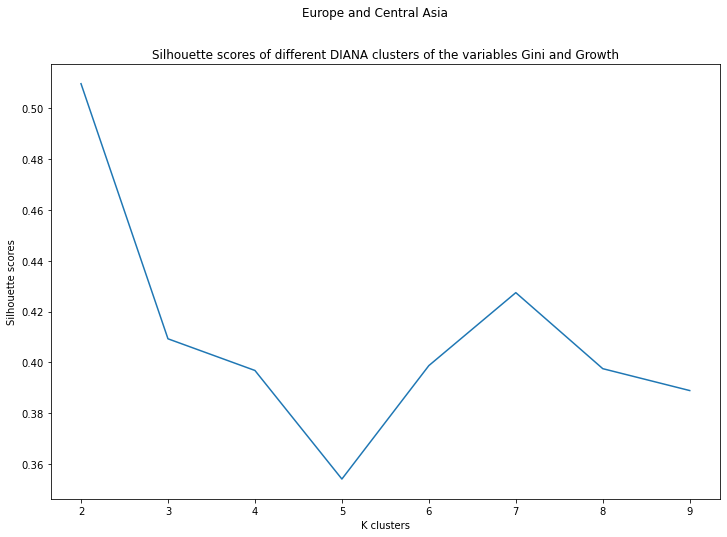

In [127]:
fig = plt.figure(figsize = (12,8))
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1])
plt.title("Silhouette scores of different DIANA clusters of the variables Gini and Growth")
plt.ylabel("Silhouette scores")
plt.xlabel("K clusters")
plt.suptitle("Europe and Central Asia")
plt.show()

In [128]:
DIANA(df_Gini_Growth_EU_CA_D, 7)

array([4., 5., 5., 2., 2., 4., 1., 5., 4., 2., 2., 4., 2., 4., 1., 5., 0.,
       5., 2., 3., 0., 6., 6., 6., 0., 1., 4., 6., 1., 2., 1., 2., 4., 0.,
       1., 1., 1., 2., 2., 0., 6., 4., 3., 2., 4.])

In [129]:
df_Gini_Growth_EU_CA['ClusterID_D'] = [round(float(i)) for i in [4., 5., 5., 2., 2., 4., 1., 5., 4., 2., 2., 4., 2., 4., 1., 5., 0.,
       5., 2., 3., 0., 6., 6., 6., 0., 1., 4., 6., 1., 2., 1., 2., 4., 0.,
       1., 1., 1., 2., 2., 0., 6., 4., 3., 2., 4.]]

In [130]:
df_Gini_Growth_EU_CA['ClusterID_D'].value_counts()

2    11
4     9
1     8
5     5
0     5
6     5
3     2
Name: ClusterID_D, dtype: int64

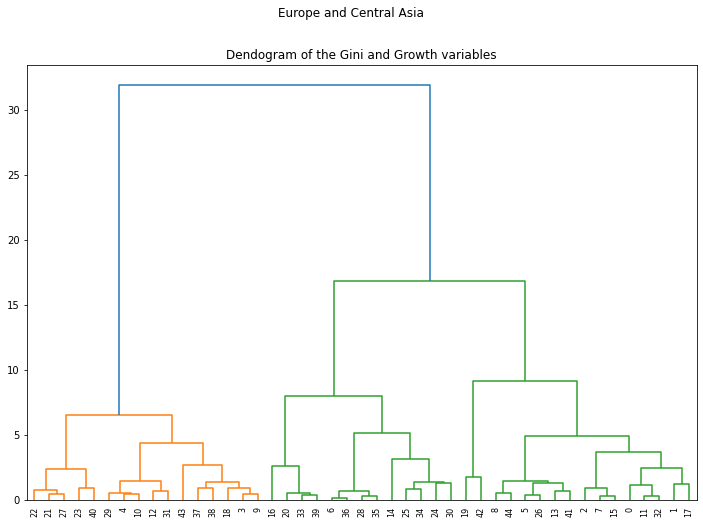

In [131]:
fig = plt.figure(figsize = (12,8))
plt.title('Dendogram of the Gini and Growth variables')
plt.suptitle("Europe and Central Asia")
dend = shc.dendrogram(shc.linkage(df_Gini_Growth_EU_CA_D, method = 'ward'))

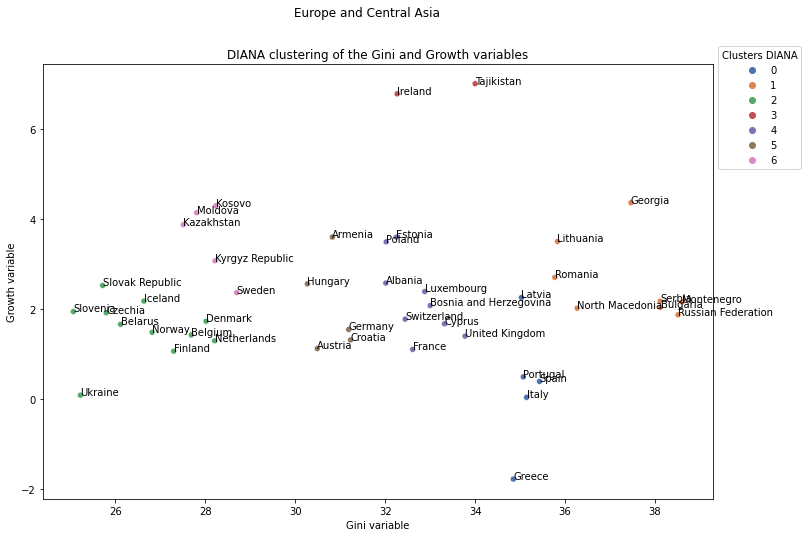

In [132]:
fig = plt.figure(figsize = (12,8))
sns.scatterplot(x='Gini_Var', y = 'Growth_Var', hue = 'ClusterID_D', legend = 'full', palette="deep", data = df_Gini_Growth_EU_CA)
plt.title('DIANA clustering of the Gini and Growth variables')
plt.suptitle("Europe and Central Asia")
plt.ylabel("Growth variable")
plt.xlabel("Gini variable")
label_point(df_Gini_Growth_EU_CA.Gini_Var, df_Gini_Growth_EU_CA.Growth_Var, df_Gini_Growth_EU_CA.Country, plt.gca()) 
plt.legend(title='Clusters DIANA', loc='center left', bbox_to_anchor = (1,0.9))
plt.show()

In [133]:
Cluster_Growth = pd.DataFrame(df_Gini_Growth_EU_CA.groupby(['ClusterID_D']).Growth_Var.mean())
Cluster_Gini = pd.DataFrame(df_Gini_Growth_EU_CA.groupby(['ClusterID_KM']).Gini_Var.mean())
dt_EU_CA_km_Growth_Gini = pd.concat([Cluster_Growth, Cluster_Gini], axis = 1)
dt_EU_CA_km_Growth_Gini

,Growth_Var,Gini_Var
0,0.278723,32.161868
1,2.603828,36.476641
2,1.572072,27.068109
3,6.897026,NaN
4,2.231155,NaN
5,2.026878,NaN
6,3.549316,NaN
